# Data Preprocessing

### Load the Data
The first step we take is to load the binary dataset into the program.


In [75]:
import pathlib
import pandas as pd
import numpy as np
import argparse
from settings import *

def load_multi_data():
    print('Loading multi-class data...')
    X_train_path = pathlib.Path().joinpath(MULTI_DIR, 'X_train.csv')
    X_train_df = pd.read_csv(X_train_path, header=None)
    X_train_df.info()

    y_train_path = pathlib.Path().joinpath(MULTI_DIR, 'Y_train.csv')
    y_train_df = pd.read_csv(y_train_path, header=None)
    print('Unique values', y_train_df.iloc[:, 0].unique())

    X_test_path = pathlib.Path().joinpath(MULTI_DIR, 'X_test.csv')
    X_test_df = pd.read_csv(X_test_path, header=None)
    X_test_df.info()

    data_dict = {
        'X_train': X_train_df,
        'X_test': X_test_df,
        'y_train': y_train_df
    }
    print('\n')

    return data_dict


In [76]:
data_dict = load_multi_data()

Loading multi-class data...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62210 entries, 0 to 62209
Columns: 964 entries, 0 to 963
dtypes: float64(964)
memory usage: 457.5 MB
Unique values ['whitecoat' 'moulted pup' 'dead pup' 'juvenile' 'background']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20335 entries, 0 to 20334
Columns: 964 entries, 0 to 963
dtypes: float64(964)
memory usage: 149.6 MB




### Clean The Data
We clean the data by removing the features taken from a random normal distribution.


In [77]:
def clean_data(data_dict):
    print('Cleaning data...')
    X_train_df = data_dict['X_train']
    X_test_df = data_dict['X_test']
    y_train_df = data_dict['y_train']

    X_train_df = X_train_df.drop(X_train_df.columns[900:916], axis=1)  # df.columns is zero-based pd.Index
    X_test_df = X_test_df.drop(X_test_df.columns[900:916], axis=1)  # df.columns is zero-based pd.Index

    print('X train after cleaning:')
    X_train_df.info()
    print('X_test after cleaning')
    X_test_df.info()
    data_dict = {
        'X_train': X_train_df,
        'X_test': X_test_df,
        'y_train': y_train_df
    }
    print('\n')
    return data_dict

In [78]:
data_dict = clean_data(data_dict)

Cleaning data...
X train after cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62210 entries, 0 to 62209
Columns: 948 entries, 0 to 963
dtypes: float64(948)
memory usage: 449.9 MB
X_test after cleaning
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20335 entries, 0 to 20334
Columns: 948 entries, 0 to 963
dtypes: float64(948)
memory usage: 147.1 MB




### Visualise Data
We visualise the target frequencies to see whether the dataset is imbalanced.

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_hog_distribution(data_dict):
    pass


def plot_target_frequency(data_dict):
    y_train = data_dict['y_train']
    y_train.columns = ['label']
    print(y_train.columns)
    total = float(len(y_train))
    print('total', total)
    plot = sns.countplot(x='label', data=y_train)
    for p in plot.patches:
        height = p.get_height()
        plot.text(p.get_x() + p.get_width() / 2.,
                height + 3,
                '{:1.3f}'.format(height / total),
                ha="center")
    plt.show()

Index(['label'], dtype='object')
total 62210.0


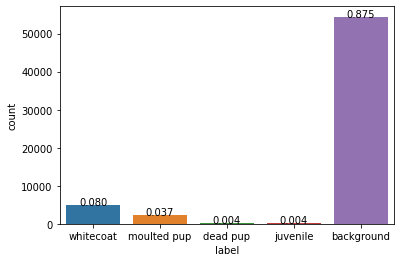

In [6]:
plot_target_frequency(data_dict)

### Split training dataset to have a mock test set
We split the dataset in order to obtain a mock test set, since we don't have the target labes that correspond to the data in the X_test.csv file.

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_val, y_train, y_val = train_test_split(data_dict['X_train'], data_dict['y_train'], test_size=0.2, random_state=23, shuffle=True, stratify=data_dict['y_train'])

### Obtain undersampled dataset
Undersample the data that  will be used for  training. We do not undersample the mock testing set as we want to keep the distribution of the classes close to the distribution of the original dataset.

In [9]:
from imblearn.under_sampling import RandomUnderSampler

In [10]:
rus = RandomUnderSampler(random_state=0)

In [11]:
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

Index(['label'], dtype='object')
total 990.0


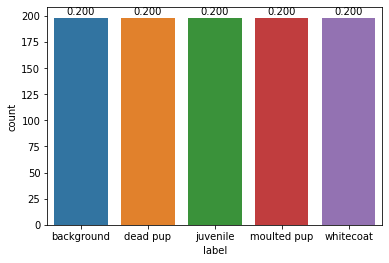

In [12]:
data_dict_under = {
    'y_train': y_train_under
}
plot_target_frequency(data_dict_under)


### Prepare Inputs 

We convert the dataframes into numpy ndarrays.

In [13]:
X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
y_train = y_train.to_numpy().ravel()
y_val = y_val.to_numpy().ravel()

In [14]:
X_train_under = X_train_under.to_numpy()
y_train_under = y_train_under.to_numpy().ravel()

# Machine  Learning

### Create Scorer

We define the scoring metrics to be used during cross-validation.

In [15]:
scorer = ['balanced_accuracy', 'accuracy']

### Training KNN
Here we define our estimator as well as the grid search. The estimator is a pipeline in which the features are scaled, PCA is perfromed and a KNN classifier is trained. 

In [16]:
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, GridSearchCV

In [17]:
def kn_cross_validate_pca(X_train, y_train, scorer):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    pipeline = Pipeline(
        [('sc', StandardScaler()), ('pca', PCA(n_components=0.99, svd_solver='full')), ('cf', KNeighborsClassifier())])

    params = {
        'cf__n_neighbors': [3],
        'cf__leaf_size': [30],
        'cf__p': [2] 
    }
    
    print('Grid: ', params)
    
    print('Scorer: ', scorer)
    
    cf = GridSearchCV(pipeline, params, cv=kf, n_jobs=-1, scoring=scorer, refit=scorer[0])

    start = time.time()
    cf.fit(X_train, y_train)
    end = time.time()
    print('K-nearest neighbors cross-val time elapsed: ', end - start)

    print('Best params: ', cf.best_params_)    

    print('PCA number of components', cf.best_estimator_.named_steps['pca'].n_components_)

    balanced_acc_score = cf.best_score_ * 100
    
    acc_score =  cf.cv_results_['mean_test_accuracy'][cf.best_index_] * 100

    print("Best cross-val balanced accuracy score: " + str(round(balanced_acc_score, 2)) + '%')
    print("Best cross-val accuracy score: " + str(round(acc_score, 2)) + '%')
    
    cv_results = pd.DataFrame(cf.cv_results_)
    display(cv_results)

    print('\n')
    return cf.best_estimator_

In [18]:
knn_cf = kn_cross_validate_pca(X_train, y_train, scorer)

Grid:  {'cf__n_neighbors': [3], 'cf__leaf_size': [30], 'cf__p': [2]}
Scorer:  ['balanced_accuracy', 'accuracy']
K-nearest neighbors cross-val time elapsed:  931.95334815979
Best params:  {'cf__leaf_size': 30, 'cf__n_neighbors': 3, 'cf__p': 2}
PCA number of components 473
Best cross-val balanced accuracy score: 32.97%
Best cross-val accuracy score: 91.79%


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cf__leaf_size,param_cf__n_neighbors,param_cf__p,params,split0_test_balanced_accuracy,split1_test_balanced_accuracy,...,std_test_balanced_accuracy,rank_test_balanced_accuracy,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,58.317384,20.501867,470.081813,74.525644,30,3,2,"{'cf__leaf_size': 30, 'cf__n_neighbors': 3, 'c...",0.336869,0.330537,...,0.007215,1,0.91732,0.921137,0.918626,0.914599,0.917613,0.917859,0.002113,1


### Making predictions on the validation set with KNN

Make predictions on the validation set and evaluate the classifier's performance.


In [19]:
y_pred = knn_cf.predict(X_val)

### Confusion matrix for KNN
The confusion matrix will tell us how each class was misclassified. 

In [20]:
from sklearn.metrics import confusion_matrix

In [21]:
cf = confusion_matrix(y_val, y_pred)

In [22]:
import seaborn as sns
import numpy as np

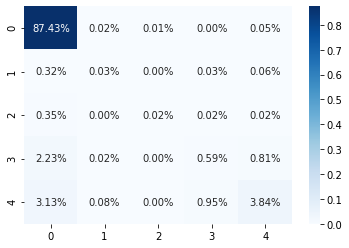

In [23]:
sns.heatmap(cf/np.sum(cf), annot=True, fmt='.2%', cmap='Blues')

### Classification report for KNN
The classification report will give us detailed evaluation metrics.

In [24]:
from sklearn.metrics import classification_report

In [25]:
cr = classification_report(y_val, y_pred)

In [26]:
print(cr)

              precision    recall  f1-score   support

  background       0.94      1.00      0.97     10887
    dead pup       0.21      0.07      0.11        55
    juvenile       0.67      0.04      0.08        50
 moulted pup       0.37      0.16      0.22       454
   whitecoat       0.80      0.48      0.60       996

    accuracy                           0.92     12442
   macro avg       0.60      0.35      0.40     12442
weighted avg       0.90      0.92      0.90     12442



In [27]:
from sklearn.metrics import balanced_accuracy_score

print('Balanced accuracy: ', balanced_accuracy_score(y_val, y_pred))

Balanced accuracy:  0.3505226457938205


### Train KNN with undersampled dataset
Here, we train the KNN classifier using the undersampled dataset.


In [28]:
knn_cf_under = kn_cross_validate_pca(X_train_under, y_train_under, scorer)

Grid:  {'cf__n_neighbors': [3], 'cf__leaf_size': [30], 'cf__p': [2]}
Scorer:  ['balanced_accuracy', 'accuracy']
K-nearest neighbors cross-val time elapsed:  4.501712083816528
Best params:  {'cf__leaf_size': 30, 'cf__n_neighbors': 3, 'cf__p': 2}
PCA number of components 383
Best cross-val balanced accuracy score: 40.21%
Best cross-val accuracy score: 39.9%


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cf__leaf_size,param_cf__n_neighbors,param_cf__p,params,split0_test_balanced_accuracy,split1_test_balanced_accuracy,...,std_test_balanced_accuracy,rank_test_balanced_accuracy,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,1.46748,0.4853,0.158707,0.030997,30,3,2,"{'cf__leaf_size': 30, 'cf__n_neighbors': 3, 'c...",0.408938,0.458958,...,0.035765,1,0.388889,0.474747,0.434343,0.333333,0.363636,0.39899,0.050303,1


### Making predictions on evaluation set with KNN trained on the undersampled dataset
We use the KNN classifier trained using the undersampled dataset to make predictions on the validation set to allow  us to evaluate its performance.

In [29]:
y_pred_under = knn_cf_under.predict(X_val)

### Confusion matrix for KNN trained on the  undersampled dataset
The confusion matrix will tell us how each class was misclassified. 


In [30]:
cf_under = confusion_matrix(y_val, y_pred_under)

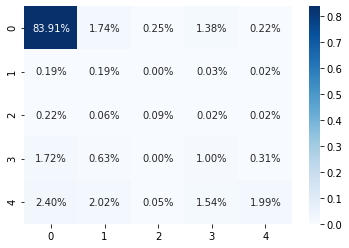

In [31]:
# sns.heatmap(cf_under, annot=True, fmt='g', cmap='Blues')
sns.heatmap(cf_under/np.sum(cf_under), annot=True, fmt='.2%', cmap='Blues')

### Classification report for KNN trained on the undersampled dataset
The classification report will give us detailed evaluation metrics.

In [32]:
cr_under = classification_report(y_val, y_pred_under)

In [33]:
print(cr_under)

              precision    recall  f1-score   support

  background       0.95      0.96      0.95     10887
    dead pup       0.04      0.44      0.08        55
    juvenile       0.23      0.22      0.22        50
 moulted pup       0.25      0.27      0.26       454
   whitecoat       0.78      0.25      0.38       996

    accuracy                           0.87     12442
   macro avg       0.45      0.43      0.38     12442
weighted avg       0.90      0.87      0.88     12442



### Training Random Forest Classifier
Here we define our estimator as well as the grid search. The estimator is a pipeline in which the features are scaled, PCA is perfromed and a RandomForest classifier is trained. 


In [34]:
from sklearn.ensemble import RandomForestClassifier

In [35]:
def rf_cross_validate_pca(X_train, y_train, scorer):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    pipeline = Pipeline(
        [('sc', StandardScaler()), ('pca', PCA(n_components=0.99, svd_solver='full')), ('cf', RandomForestClassifier())])

    params = {
        'cf__n_estimators': [400],
        'cf__max_depth': [None],
        'cf__min_samples_split': [2],
    }
    
    print('Grid: ', params)
    
    print('Scorer: ', scorer)
    
    cf = GridSearchCV(pipeline, params, cv=kf, n_jobs=-1, scoring=scorer, refit=scorer[0])

    start = time.time()
    cf.fit(X_train, y_train)
    end = time.time()
    print('Random Forest cross-val time elapsed: ', end - start)

    print('Best params: ', cf.best_params_)    

    print('PCA number of components', cf.best_estimator_.named_steps['pca'].n_components_)

    balanced_acc_score = cf.best_score_ * 100
    
    acc_score =  cf.cv_results_['mean_test_accuracy'][cf.best_index_] * 100

    print("Best cross-val balanced accuracy score: " + str(round(balanced_acc_score, 2)) + '%')
    print("Best cross-val accuracy score: " + str(round(acc_score, 2)) + '%')
    
    cv_results = pd.DataFrame(cf.cv_results_)
    display(cv_results)

    print('\n')
    return cf.best_estimator_

In [36]:
rf_cf = rf_cross_validate_pca(X_train, y_train, scorer)

Grid:  {'cf__n_estimators': [400], 'cf__max_depth': [None], 'cf__min_samples_split': [2]}
Scorer:  ['balanced_accuracy', 'accuracy']
Random Forest cross-val time elapsed:  4503.3635902404785
Best params:  {'cf__max_depth': None, 'cf__min_samples_split': 2, 'cf__n_estimators': 400}
PCA number of components 473
Best cross-val balanced accuracy score: 28.85%
Best cross-val accuracy score: 91.01%


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cf__max_depth,param_cf__min_samples_split,param_cf__n_estimators,params,split0_test_balanced_accuracy,split1_test_balanced_accuracy,...,std_test_balanced_accuracy,rank_test_balanced_accuracy,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,1701.551985,271.003517,2.80028,0.651569,None,2,400,"{'cf__max_depth': None, 'cf__min_samples_split...",0.288162,0.296451,...,0.004614,1,0.908579,0.916114,0.914406,0.906762,0.904752,0.910123,0.004399,1


### Making predictions on the validation set with RF
We use the RF classifier to make predictions on the validation set to allow  us to evaluate its performance.

In [37]:
y_pred = rf_cf.predict(X_val)

### Confusion matrix for RF
The confusion matrix will tell us how each class was misclassified. 

In [38]:
from sklearn.metrics import confusion_matrix

In [39]:
cf = confusion_matrix(y_val, y_pred)

In [40]:
import seaborn as sns
import numpy as np

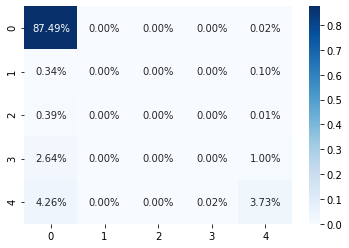

In [41]:
sns.heatmap(cf/np.sum(cf), annot=True, fmt='.2%', cmap='Blues')

### Classification report for RF
The classification report will give us detailed evaluation metrics.

In [42]:
from sklearn.metrics import classification_report

In [43]:
cr = classification_report(y_val, y_pred)

/Users/alexandrosmichael/Desktop/CS/CS5014/Practicals/P2/virtualenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
print(cr)

              precision    recall  f1-score   support

  background       0.92      1.00      0.96     10887
    dead pup       0.00      0.00      0.00        55
    juvenile       0.00      0.00      0.00        50
 moulted pup       0.00      0.00      0.00       454
   whitecoat       0.77      0.47      0.58       996

    accuracy                           0.91     12442
   macro avg       0.34      0.29      0.31     12442
weighted avg       0.87      0.91      0.88     12442



In [45]:
from sklearn.metrics import balanced_accuracy_score

print('Balanced accuracy: ', balanced_accuracy_score(y_val, y_pred))

Balanced accuracy:  0.2931359496957242


### Train RF with undersampled dataset
Here, we train the RandomForest classifier using the undersampled dataset.

In [46]:
rf_cf_under = rf_cross_validate_pca(X_train_under, y_train_under, scorer)

Grid:  {'cf__n_estimators': [400], 'cf__max_depth': [None], 'cf__min_samples_split': [2]}
Scorer:  ['balanced_accuracy', 'accuracy']
Random Forest cross-val time elapsed:  21.88902711868286
Best params:  {'cf__max_depth': None, 'cf__min_samples_split': 2, 'cf__n_estimators': 400}
PCA number of components 383
Best cross-val balanced accuracy score: 55.67%
Best cross-val accuracy score: 54.95%


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cf__max_depth,param_cf__min_samples_split,param_cf__n_estimators,params,split0_test_balanced_accuracy,split1_test_balanced_accuracy,...,std_test_balanced_accuracy,rank_test_balanced_accuracy,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,8.561392,1.96284,0.212396,0.109098,None,2,400,"{'cf__max_depth': None, 'cf__min_samples_split...",0.498373,0.544891,...,0.033854,1,0.489899,0.555556,0.606061,0.525253,0.570707,0.549495,0.039562,1


### Making prediction on evaluation set with RF trained on undersampled dataset
We use the RF classifier trained using the undersampled dataset to make predictions on the validation set to allow  us to evaluate its performance.

In [47]:
y_pred_under = rf_cf_under.predict(X_val)

### Confusion matrix for RF trained on undersampled dataset
The confusion matrix will tell us how each class was misclassified. 

In [48]:
cf_under = confusion_matrix(y_val, y_pred_under)

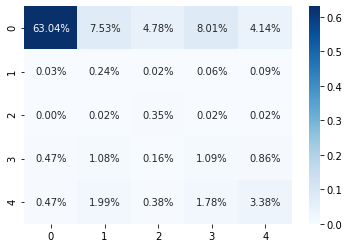

In [49]:
sns.heatmap(cf_under/np.sum(cf_under), annot=True, fmt='.2%', cmap='Blues')

### Classification report for RF trained on undersampled dataset
The classification report will give us detailed evaluation metrics.

In [50]:
cr_under = classification_report(y_val, y_pred_under)

In [51]:
print(cr_under)

              precision    recall  f1-score   support

  background       0.98      0.72      0.83     10887
    dead pup       0.02      0.55      0.04        55
    juvenile       0.06      0.86      0.11        50
 moulted pup       0.10      0.30      0.15       454
   whitecoat       0.40      0.42      0.41       996

    accuracy                           0.68     12442
   macro avg       0.31      0.57      0.31     12442
weighted avg       0.90      0.68      0.77     12442



### Training SVM  Classifier
Here we define our estimator as well as the grid search. The estimator is a pipeline in which the features are scaled, PCA is perfromed and an SVC classifier is trained. 


In [52]:
from sklearn.svm import LinearSVC

In [53]:
def svc_cross_validate_pca(X_train, y_train, scorer):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    pipeline = Pipeline(
        [('sc', StandardScaler()), ('pca', PCA(n_components=0.99, svd_solver='full')), ('cf', LinearSVC())])

    params = {
        'cf__C': [1.0],
        'cf__loss': ['squared_hinge'],
        'cf__dual': [False],
    }
    
    print('Grid: ', params)
    
    print('Scorer: ', scorer)
    
    cf = GridSearchCV(pipeline, params, cv=kf, n_jobs=-1, scoring=scorer, refit=scorer[0])

    start = time.time()
    cf.fit(X_train, y_train)
    end = time.time()
    print('SVC cross-val time elapsed: ', end - start)

    print('Best params: ', cf.best_params_)    

    print('PCA number of components', cf.best_estimator_.named_steps['pca'].n_components_)

    balanced_acc_score = cf.best_score_ * 100
    
    acc_score =  cf.cv_results_['mean_test_accuracy'][cf.best_index_] * 100

    print("Best cross-val balanced accuracy score: " + str(round(balanced_acc_score, 2)) + '%')
    print("Best cross-val accuracy score: " + str(round(acc_score, 2)) + '%')
    
    cv_results = pd.DataFrame(cf.cv_results_)
    display(cv_results)

    print('\n')
    return cf.best_estimator_

In [54]:
svc_cf = svc_cross_validate_pca(X_train, y_train, scorer)

Grid:  {'cf__C': [1.0], 'cf__loss': ['squared_hinge'], 'cf__dual': [False]}
Scorer:  ['balanced_accuracy', 'accuracy']
SVC cross-val time elapsed:  274.38257098197937
Best params:  {'cf__C': 1.0, 'cf__dual': False, 'cf__loss': 'squared_hinge'}
PCA number of components 473
Best cross-val balanced accuracy score: 47.07%
Best cross-val accuracy score: 94.03%


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cf__C,param_cf__dual,param_cf__loss,params,split0_test_balanced_accuracy,split1_test_balanced_accuracy,...,std_test_balanced_accuracy,rank_test_balanced_accuracy,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,141.774747,43.031581,0.948483,0.358421,1,False,squared_hinge,"{'cf__C': 1.0, 'cf__dual': False, 'cf__loss': ...",0.472094,0.457167,...,0.008834,1,0.938618,0.941431,0.943741,0.939214,0.938511,0.940303,0.002016,1


### Making predictions on the validation set with SVC
We use the SVC classifier to make predictions on the validation set to allow  us to evaluate its performance.

In [55]:
y_pred = svc_cf.predict(X_val)

### Confusion matrix for SVC
The confusion matrix will tell us how each class was misclassified. 

In [56]:
from sklearn.metrics import confusion_matrix

In [57]:
cf = confusion_matrix(y_val, y_pred)

In [58]:
import seaborn as sns
import numpy as np

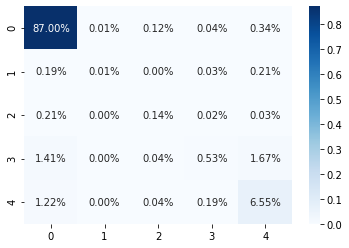

In [59]:
sns.heatmap(cf/np.sum(cf), annot=True, fmt='.2%', cmap='Blues')

### Classification report for RF
The classification report will give us detailed evaluation metrics.

In [60]:
from sklearn.metrics import classification_report

In [61]:
cr = classification_report(y_val, y_pred)

In [62]:
print(cr)

              precision    recall  f1-score   support

  background       0.97      0.99      0.98     10887
    dead pup       0.50      0.02      0.04        55
    juvenile       0.42      0.36      0.39        50
 moulted pup       0.65      0.15      0.24       454
   whitecoat       0.74      0.82      0.78       996

    accuracy                           0.94     12442
   macro avg       0.66      0.47      0.48     12442
weighted avg       0.93      0.94      0.93     12442



In [63]:
from sklearn.metrics import balanced_accuracy_score

print('Balanced accuracy: ', balanced_accuracy_score(y_val, y_pred))

Balanced accuracy:  0.46720852835726845


### Train SVC with undersampled dataset
Here, we train the SVC classifier using the undersampled dataset.

In [64]:
svc_cf_under = svc_cross_validate_pca(X_train_under, y_train_under, scorer)

Grid:  {'cf__C': [1.0], 'cf__loss': ['squared_hinge'], 'cf__dual': [False]}
Scorer:  ['balanced_accuracy', 'accuracy']
SVC cross-val time elapsed:  40.17562389373779
Best params:  {'cf__C': 1.0, 'cf__dual': False, 'cf__loss': 'squared_hinge'}
PCA number of components 383
Best cross-val balanced accuracy score: 52.26%
Best cross-val accuracy score: 52.02%


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cf__C,param_cf__dual,param_cf__loss,params,split0_test_balanced_accuracy,split1_test_balanced_accuracy,...,std_test_balanced_accuracy,rank_test_balanced_accuracy,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,20.076202,5.816949,0.016708,0.005843,1,False,squared_hinge,"{'cf__C': 1.0, 'cf__dual': False, 'cf__loss': ...",0.483779,0.533871,...,0.019753,1,0.479798,0.540404,0.550505,0.494949,0.535354,0.520202,0.027663,1


### Making prediction on evaluation set with SVC trained on undersampled dataset
We use the SVC classifier trained using the undersampled dataset to make predictions on the validation set to allow  us to evaluate its performance.

In [65]:
y_pred_under = svc_cf_under.predict(X_val)

### Confusion matrix for SVC trained on undersampled dataset
The confusion matrix will tell us how each class was misclassified. 

In [66]:
cf_under = confusion_matrix(y_val, y_pred_under)

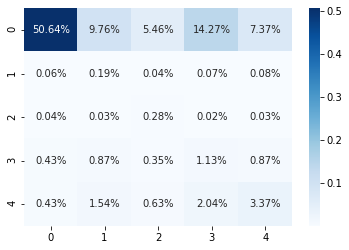

In [67]:
sns.heatmap(cf_under/np.sum(cf_under), annot=True, fmt='.2%', cmap='Blues')

### Classification report for SVC trained on undersampled dataset
The classification report will give us detailed evaluation metrics.

In [68]:
cr_under = classification_report(y_val, y_pred_under)

In [69]:
print(cr_under)

              precision    recall  f1-score   support

  background       0.98      0.58      0.73     10887
    dead pup       0.02      0.44      0.03        55
    juvenile       0.04      0.70      0.08        50
 moulted pup       0.06      0.31      0.11       454
   whitecoat       0.29      0.42      0.34       996

    accuracy                           0.56     12442
   macro avg       0.28      0.49      0.26     12442
weighted avg       0.88      0.56      0.67     12442



## Produce the Y_test.csv file

This is the file that will be used to evaluate the final performance of the classifier. After analysing the results we decided that we will be using the SVM classifier that was trained on the original dataset. 

In [79]:
X_test = data_dict['X_test']

In [80]:
y_test = svc_cf.predict(X_test)
print(len(y_test))

20335


In [81]:
output_path = pathlib.Path().joinpath(MULTI_DIR, 'Y_test.csv')
np.savetxt(output_path, y_test, fmt="%s")